# Selective SSM

Authors: Chase T. Grajeda, Stefan T. Radev

### Imports

In [1]:
import os
import sys
os.environ["KERAS_BACKEND"] = "torch"

import torch
import keras
import numpy as np
import pickle as pkl

import bayesflow as bf

# clear session
keras.backend.clear_session()

/home/chase/miniconda3/envs/ssm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:bayesflow:Using backend 'torch'


### Verify GPU is accessible

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print("Available devices:", torch.cuda.device_count())

NVIDIA GeForce GTX 1650 Ti with Max-Q Design
Available devices: 1


### Verify Keras sees GPU

In [3]:
keras.random.normal((5,5)).to("cuda")

tensor([[ 0.9074,  1.0468, -0.5294,  0.4744,  0.5312],
        [ 1.6672, -1.3935, -1.6785,  0.3009,  0.5167],
        [ 0.5966, -0.5691,  1.5980,  1.8516,  0.2264],
        [ 0.5472,  0.3112, -0.5111, -0.4615,  0.6149],
        [ 1.1099, -1.3990,  0.9265, -0.5470,  0.2969]], device='cuda:0')

### Test pass on Mamba

In [4]:
test_mamba = bf.wrappers.MambaSSM(
    ssm_dim=16,
    state_dim=16,
    mamba_blocks=3,
    conv_dim=4,
    expand=2,
    summary_dim=8,
    dt_min=0.01,
    dt_max=0.5,
    pooling=True,
    dropout=0.5,
    mamba_version=1, # TODO: add support for Mamba2
    device="cuda"
)

In [5]:
x = keras.random.normal((2, 64, 16)).to("cuda")
z = test_mamba(x)
print(z)
print(z.shape)

tensor([[-5.3528e-03, -1.9847e-02, -5.7641e-03,  2.6516e-02, -1.3306e-02,
          1.3155e-02,  1.0571e-06, -2.0714e-02],
        [-2.7471e-02,  1.6958e-02,  5.3370e-03,  1.8915e-03, -8.2082e-04,
          1.9611e-02, -1.4537e-02,  1.5915e-02]], device='cuda:0')
torch.Size([2, 8])


In [6]:
# LV Wrapper Mamba-ssm pass
lv = bf.benchmarks.LotkaVolterra(
	X0=30,
	Y0=1,
	T=100,
	subsample=50,
	flatten=False,
	obs_noise=0.1,
	dt=None,
	rng=None
)

params = lv.prior()
obs = lv.observation_model(params)
x = keras.ops.expand_dims(obs, 0)

print(x.shape)

torch.Size([1, 50, 2])


### Test Model

In [7]:
keras.backend.clear_session()

# rng = np.random.default_rng(seed=1111)
simulator = bf.benchmarks.LotkaVolterra(
	X0=30,
	Y0=1,
	T=20,
	subsample=None,
	flatten=False,
	obs_noise=0.1,
	dt=0.01, # 1 / time
	rng=None
)

samples = simulator.sample(5)
print([key for key in samples.keys()])
print("Parameter Shape:", samples["parameters"].shape)
print("Observable Shape:", samples["observables"].shape)

['parameters', 'observables']
Parameter Shape: (5, 4)
Observable Shape: (5, 100, 2)


In [8]:
summarynet = bf.wrappers.MambaSSM(
    ssm_dim=2,
    state_dim=256,
    mamba_blocks=10,
    conv_dim=8,
    expand=4,
    summary_dim=32,
    pooling=True,
    dropout=0.5,
    mamba_version=1,
    device="cuda"
)

# Input shape is (B, L, D)
# B = batch size
# L = length (time)
# D = feature dim
x = samples["observables"][0:1, :, :]
z = summarynet(x)
print(z)
print(z.shape)

tensor([[-0.1229,  1.5290,  0.3292, -1.2228,  0.8865,  1.1090,  2.1300,  3.2365,
         -1.9665,  0.8833,  0.9911, -0.6218,  3.8317,  3.2603,  1.1421, -1.4851,
          0.8659, -1.1588, -1.3376, -1.8014,  1.4822, -1.3326,  0.2478,  0.8167,
          2.7402,  0.6087, -1.0404, -3.1608, -2.2019, -1.0691,  2.5794, -1.0745]],
       device='cuda:0')
torch.Size([1, 32])


In [9]:
# Show number of parameters
single_block = summarynet.mamba_blocks[0]
params = sum(p.numel() for p in single_block.parameters()) * len(summarynet.mamba_blocks)
print("Total params:", params)

Total params: 62960


In [10]:
adapter = (
	bf.adapters.Adapter()
	.as_time_series("observables")
	.rename("parameters", "inference_variables")
	.rename("observables", "summary_variables")
	.apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
)

inference_net = bf.networks.FlowMatching(subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (512,) * 4})

workflow = bf.BasicWorkflow(
	simulator=simulator,
	adapter=adapter,
	inference_network=inference_net,
	summary_network=summarynet
)

In [11]:
if os.path.exists("training_data.pickle") and os.path.exists("validation_data.pickle"):
    with open("training_data.pickle", 'rb') as f:
        training_data = pkl.load(f)
    with open("validation_data.pickle", 'rb') as f:
        validation_data = pkl.load(f)
else:
    training_data = workflow.simulate(10000)
    validation_data = workflow.simulate(300)
    with open("training_data.pickle", 'wb') as f:
        pkl.dump(training_data, f)
    with open("validation_data.pickle", 'wb') as f:
        pkl.dump(validation_data, f)

In [12]:
history = workflow.fit_offline(training_data, epochs=20, batch_size=64, validation_data=validation_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.2569 - loss/inference_loss: 0.2569 - val_loss: 0.1513 - val_loss/inference_loss: 0.1513
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 0.1933 - loss/inference_loss: 0.1933 - val_loss: 0.1814 - val_loss/inference_loss: 0.1814
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 0.1773 - loss/inference_loss: 0.1773 - val_loss: 0.2057 - val_loss/inference_loss: 0.2057
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.1758 - loss/inference_loss: 0.1758 - val_loss: 0.2095 - val_loss/inference_loss: 0.2095
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.1702 - loss/inference_loss: 0.1702 - val_loss: 0.1813 - val_loss/inference_loss: 0.1813
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 0.1654 - loss/inference_loss: 0.1654 - val_loss: 0.1859 - val_loss/inference_loss: 0.1859
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 0.1542 - loss/infer

In [13]:
test_sims = workflow.simulate(300)
time_series = test_sims.pop("observables")

samples = workflow.sample(conditions={"observables": time_series}, num_samples=1000)

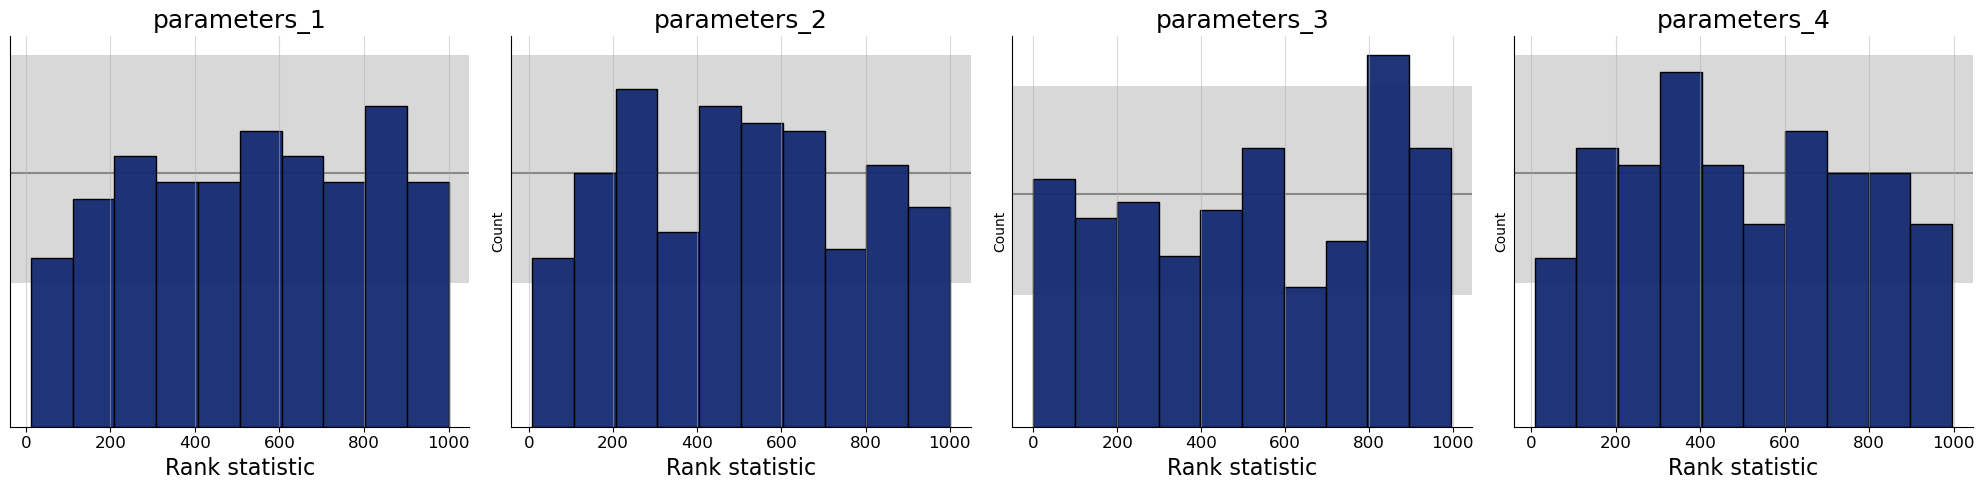

In [14]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_sims)

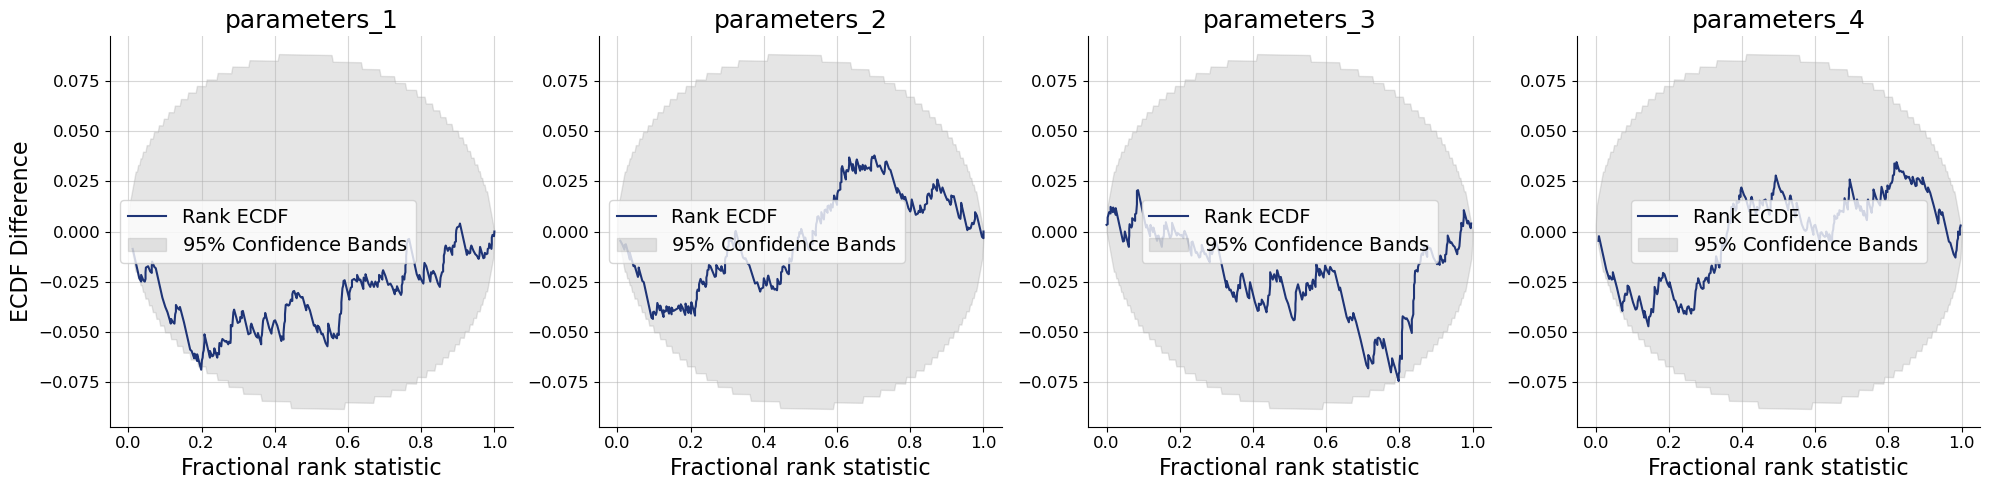

In [15]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

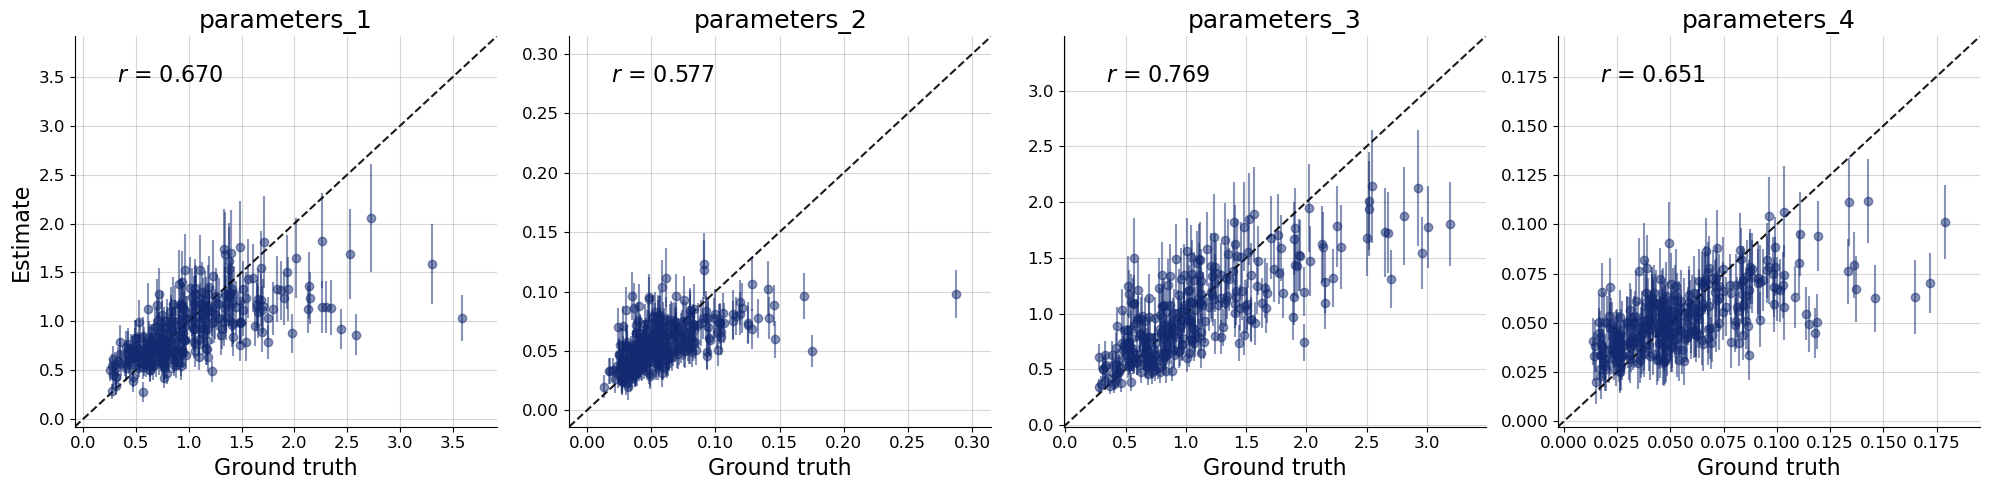

In [16]:
f = bf.diagnostics.plots.recovery(samples, test_sims)